In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

from utils.settings import METABRIC_PATH


def plot_km(surv_data, survival_clm="Survival_in_days", group_clm=None, conf = False):

    if group_clm is None:
        time, survival_prob, conf_int = kaplan_meier_estimator(
            surv_data["Status"], surv_data[survival_clm], conf_type="log-log"
        )

        plt.step(time, survival_prob, where="post")
        if conf:
            plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    else:
        for group_type in np.unique(surv_data[group_clm]):
            mask = surv_data[group_clm] == group_type
            time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
                surv_data["Status"][mask],
                surv_data[survival_clm][mask],
                conf_type="log-log",
            )

            plt.step(
                time_treatment,
                survival_prob_treatment,
                where="post",
                label=f"{group_type}",
            )
            plt.legend(loc="best")

        if conf:
            plt.fill_between(
                time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post"
            )
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")

from sksurv.compare import compare_survival

def print_chisq(surv_data, groups):
    data_y = surv_data[["Status","Survival_in_days"]].to_records(index=False)
    chisq, pvalue, stats, covar = compare_survival(data_y, groups, return_stats=True)

    print(f"Chi-square: {chisq}")
    print(f"P-value: {pvalue}")
    print(stats)

In [2]:
data = pd.read_csv(
    METABRIC_PATH, index_col=None, header=0, low_memory=False
)
data = data.drop(data[data["Pam50Subtype"] == "?"].index)
data.head()

,METABRIC_ID,Cohort,Age_At_Diagnosis,Breast_Tumour_Laterality,Date_Of_Diagnosis,Last_Followup_Status,NPI,ER_Status,Inferred_Menopausal_State,Lymph_Nodes_Positive,...,CNA_FOXM1,CNA_EXOC3,CNA_ARMC7,CNA_KCTD2,CNA_PDCD10,CNA_RHOD,CNA_CFL1,CNA_YBX1,CNA_TRIM24,CNA_RAB11FIP3
0,MB-0002,1,43.19,r,2000/12,a,4.020,pos,pre,0,...,0,0,-1,-1,0,2,2,0,-1,0
1,MB-0005,1,48.87,r,2001/02,d-d.s.,4.030,pos,pre,1,...,0,0,0,0,0,1,1,0,2,1
2,MB-0006,1,47.68,r,2001/02,a,4.050,pos,pre,3,...,0,0,0,0,0,0,0,0,1,0
3,MB-0010,1,78.77,l,2001/03,d-d.s.,4.062,pos,post,0,...,0,0,0,0,0,1,1,0,0,2
4,MB-0014,1,56.45,r,2001/04,a,4.020,pos,post,1,...,0,-1,0,0,0,0,0,0,0,0


In [4]:
from utils.data import get_data
metabric = get_data(METABRIC_PATH)
y = metabric["pam50np"]
y

array([2, 3, 3, ..., 4, 4, 1], dtype=int8)

In [6]:
df = pd.DataFrame(y, columns=["gt_classes"])
df

,gt_classes
0,2
1,3
2,3
3,3
4,3
...,...
1969,3
1970,3
1971,4
1972,4


In [13]:
df["gt_classes"].value_counts()

gt_classes
2    718
3    488
0    329
1    240
4    199
Name: count, dtype: int64

In [40]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_wts = compute_class_weight("balanced", classes=np.unique(y), y=y)
class_wts

array([1.2       , 1.645     , 0.54986072, 0.80901639, 1.9839196 ])

In [46]:
a = torch.tensor(
                class_wts, dtype=torch.float
            )

In [47]:
np.unique(a)

array([0.5498607, 0.8090164, 1.2      , 1.645    , 1.9839196],
      dtype=float32)

In [51]:
# return (args[0] - args[0].min(axis=0)) / (args[0].max(axis=0) - args[0].min(0))

class_weights = len(df["gt_classes"])/ (5*df["gt_classes"].value_counts())


class_weights.sort_index().to_list()

[1.2, 1.645, 0.5498607242339832, 0.809016393442623, 1.9839195979899498]

In [48]:
import torch
torch.tensor(
                class_weights.to_dict(), dtype=torch.float
            )

TypeError: must be real number, not dict

In [6]:
cli_clms = [col for col in data.columns if not col.startswith("GE") and not col.startswith("CNA")]
cli_clms

['METABRIC_ID',
 'Cohort',
 'Age_At_Diagnosis',
 'Breast_Tumour_Laterality',
 'Date_Of_Diagnosis',
 'Last_Followup_Status',
 'NPI',
 'ER_Status',
 'Inferred_Menopausal_State',
 'Lymph_Nodes_Positive',
 'Breast_Surgery',
 'CT',
 'HT',
 'RT',
 'Grade',
 'Size',
 'Histological_Type',
 'Stage',
 'Cellularity',
 'DeathBreast',
 'Death',
 'clin_T',
 'TLR',
 'LR',
 'TDR',
 'DR',
 'HER2_SNP6',
 'iC10',
 'Pam50Subtype',
 'ER_Expr',
 'Her2_Expr',
 'PR_Expr',
 'ClaudinSubtype',
 'Complete_Rec_History']

In [7]:
# Get data subset 
surv_data = data[["Death", "clin_T", "Pam50Subtype", "iC10"]]
surv_data = surv_data.drop(data[data["Death"] == "?"].index)
surv_data["Death"] = surv_data["Death"].astype(int).astype(bool)

surv_data = surv_data.rename(columns={"Death":"Status", "clin_T":"Survival_in_days"})

# Compute time in months
surv_data["Survival_in_months"] = surv_data["Survival_in_days"]//30
surv_data.loc[surv_data["Survival_in_months"]>200, "Survival_in_months"] = 200
surv_data

,Status,Survival_in_days,Pam50Subtype,iC10,Survival_in_months
0,False,2539,LumA,4ER+,84
1,True,4911,LumB,3,163
2,False,4948,LumB,9,164
3,True,234,LumB,7,7
4,False,4930,LumB,3,164
...,...,...,...,...,...
1975,True,1176,LumB,5,39
1976,True,1664,LumB,8,55
1977,True,746,Normal,5,24
1978,False,3329,Normal,4ER+,110


#### KM plots

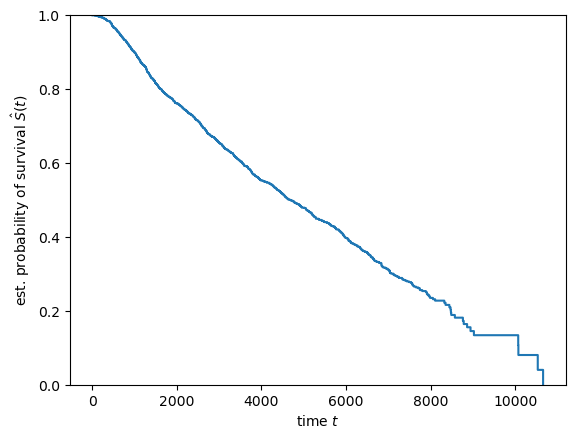

In [8]:
plot_km(surv_data)

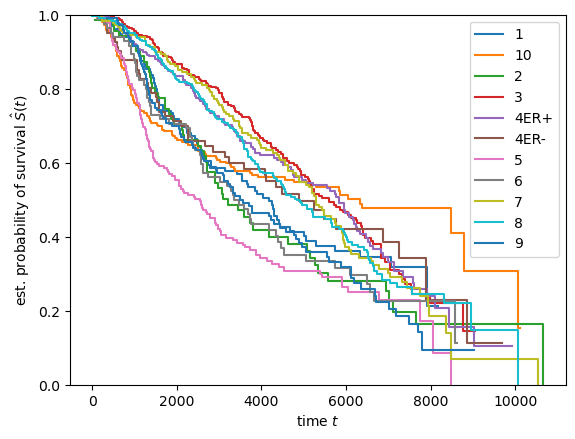

In [9]:
plot_km(surv_data, group_clm="iC10", conf=False)

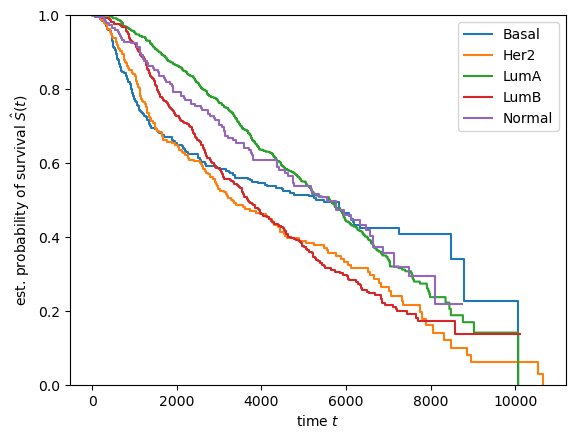

In [10]:
plot_km(surv_data, group_clm="Pam50Subtype", conf=False)

#### Chi-square

In [11]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(surv_data[["Pam50Subtype"]].astype('category'))
# 1 subtype is missing since can be represented by setting all the others to 0
data_x_numeric.head()

,Pam50Subtype=Her2,Pam50Subtype=LumA,Pam50Subtype=LumB,Pam50Subtype=Normal
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [12]:
data_y = surv_data[["Status","Survival_in_days"]].to_records(index=False)
data_y

rec.array([(False, 2539), ( True, 4911), (False, 4948), ...,
           ( True,  746), (False, 3329), ( True, 1040)],
          dtype=[('Status', '?'), ('Survival_in_days', '<i8')])

In [13]:
print_chisq(surv_data, surv_data["Pam50Subtype"])

Chi-square: 46.89120083816142
P-value: 1.6065928199240329e-09
        counts  observed    expected  statistic
group                                          
Basal      329       167  173.108053  -6.108053
Her2       240       165  125.139991  39.860009
LumA       717       385  468.086493 -83.086493
LumB       488       323  257.681200  65.318800
Normal     199        97  112.984265 -15.984265


## Predictions

In [14]:
gat_data = "/home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/GATO/results/GAT_CLI+RNA/0206124549/fold_1/predictions.csv"
df_gat = pd.read_csv(gat_data)

# pam_cat = data[["Pam50Subtype"]].astype('category')
# # df_gat["GT"] == pam_cat["Pam50Subtype"].cat.codes
# pam_cat = pam_cat["Pam50Subtype"].cat.codes.to_numpy()
# (pam_cat == df_gat["GT"].values)
# # list(data["Pam50Subtype"].values)[-1]

codes = {0:"LumA", 1:"LumB", 2:"Normal", 3:"Her2", 4:"Basal"}
df_gat["Pam50Predictions"] = [codes[i] for i in df_gat["Pred"]]
df_gat

,GT,Pred,Pam50Predictions
0,0,0,LumA
1,1,0,LumA
2,1,1,LumB
3,1,0,LumA
4,1,1,LumB
...,...,...,...
1969,1,1,LumB
1970,1,0,LumA
1971,2,4,Basal
1972,2,2,Normal


In [15]:
surv_gat = pd.merge(data[["Death", "clin_T"]].reset_index(drop=True), df_gat["Pam50Predictions"], left_index=True, right_index=True)
surv_gat = surv_gat.drop(surv_gat[surv_gat["Death"] == "?"].index)
surv_gat["Death"] = surv_gat["Death"].astype(int).astype(bool)
surv_gat = surv_gat.rename(columns={"Death":"Status", "clin_T":"Survival_in_days"})
surv_gat

,Status,Survival_in_days,Pam50Predictions
0,False,2539,LumA
1,True,4911,LumA
2,False,4948,LumB
3,True,234,LumA
4,False,4930,LumB
...,...,...,...
1969,True,1176,LumB
1970,True,1664,LumA
1971,True,746,Basal
1972,False,3329,Normal


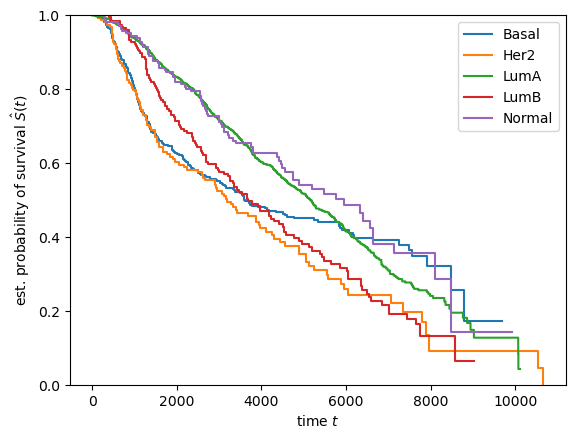

In [16]:
plot_km(surv_gat, group_clm="Pam50Predictions",conf=False)

In [17]:
print_chisq(surv_gat, surv_gat["Pam50Predictions"])

Chi-square: 37.55595976134156
P-value: 1.383594692238215e-07
        counts  observed    expected  statistic
group                                          
Basal      389       214  191.650285  22.349715
Her2       153       107   73.590052  33.409948
LumA      1068       607  672.714763 -65.714763
LumB       197       133  103.111118  29.888882
Normal     166        76   95.933782 -19.933782


,Pam50Subtype=Her2,Pam50Subtype=LumA,Pam50Subtype=LumB,Pam50Subtype=Normal
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [84]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
import numpy as np

from sksurv.preprocessing import OneHotEncoder


def pre_process_data(
    surv_data,
    survival_clm="Survival_in_days",
    groups_clm="Pam50Subtype",
):
    # 1 subtype is missing since cna be represented by setting all the others to 0
    data_x_numeric = OneHotEncoder().fit_transform(
        surv_data[[groups_clm]].astype("category")
    )
    data_y = surv_data[["Status", survival_clm]].to_records(index=False)

    return data_x_numeric, data_y


def get_c_index(data_x, data_y, pred=None, estimator=CoxPHSurvivalAnalysis()):
    set_config(display="text")  # displays text representation of estimators

    estimator.fit(data_x, data_y)

    coef = pd.Series(estimator.coef_, index=data_x.columns)
    c_index = estimator.score(data_x, data_y)
    print("\nC-index: ", c_index)
    return c_index, coef

def get_score_features(x, y, m=CoxPHSurvivalAnalysis()):
    X = x.values
    n_features = X.shape[1]
    scores = np.empty(n_features)

    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    
    scores = pd.Series(scores, index=x.columns).sort_values(ascending=False)
    print("\nFeature scores:\n", scores)
    return scores

In [85]:
x, y = pre_process_data(surv_data)
get_score_features(x,y)
c, s = get_c_index(x,y)


Feature scores:
 Pam50Subtype=LumA      0.559164
Pam50Subtype=LumB      0.526074
Pam50Subtype=Her2      0.523760
Pam50Subtype=Normal    0.508152
dtype: float64

C-index:  0.5735326973471351


In [88]:
# c, s = print_cox(surv_gat,)

x, pred = pre_process_data(surv_gat, groups_clm="Pam50Predictions")
get_score_features(x,y)
c, s = get_c_index(x,pred)



Feature scores:
 Pam50Predictions=LumA      0.553424
Pam50Predictions=Her2      0.520046
Pam50Predictions=LumB      0.510799
Pam50Predictions=Normal    0.509971
dtype: float64

C-index:  0.5650995412799478
